Author: Andrew Martin
Creation date: 15/12/22

#### Known issues:
+ Doesn't exist yet

# View Summit raw .mpl.gz Data

This notebook will be for initial viewing of the Summit data files taken directly from ncas_radar_gws_v2/data/ICECAPSarchive/mpl/raw

The workflow consists of the steps:
1. Move the required .mpl.gz files to the desired directory
2. Move to the directory of these files and run the terminal command ```gunzip . .```   This will act to unzip the files and produce the .mpl files
3. In the same directory, run ```conda activate mpl2nc``` and then run the command ```mpl2nc . .``` to convert all the .mpl files to .nc files
4. Then we can run the script. The .nc files produced have channel_1 and channel_2 as the cross-polarised and co-polarised backscatter values, which are plotted below.

### Future work:
+ I've written code to attempt to concatenate the datasets, although this crashed when I ran it. Possibly might have to run this as a LOTUS batch script (access to more memory?) and then find a way of handling the data efficiently...

In [13]:
# initial imports

# file handling
import netCDF4
import gzip
import os
import glob
import tempfile
import shutil

# data handling
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl

import warnings

In [2]:
# determining where to load the data from
root_dir = '/gws/nopw/j04/ncas_radar_vol1/eeasm/ICESAT'
root_dir_steps = ['rgt_0749','cycle_10']

root_path = os.path.join(root_dir,*root_dir_steps)

In [3]:
# get the zipped mpl files, unzip them if they exist and then delete the original zipped files
mpl_path = os.path.join(root_path,'mpl')

mpl_files_zip = [f for f in os.listdir(mpl_path) if '.mpl.gz' in f]
print(*mpl_files_zip)

In [28]:
# try opening the first .mpl file as a netcdf?
mpl_files = [f for f in os.listdir(mpl_path) if '.nc' in f]
print(*mpl_files)

#data = netCDF4.Dataset(os.path.join(root_path,'mpl',mpl_files[0]),'r')
data = xr.open_dataset(os.path.join(root_path,'mpl',mpl_files[4]))

data

202102102200.nc 202102102300.nc 202102110000.nc 202102110100.nc 202102110200.nc


<xarray.Dataset>
Dimensions:                      (profile: 720, range: 1999)
Dimensions without coordinates: profile, range
Data variables: (12/52)
    unit                         (profile) float32 ...
    version                      (profile) float32 ...
    shots_sum                    (profile) float64 ...
    trigger_frequency            (profile) float64 ...
    energy_monitor               (profile) float64 ...
    temp_0                       (profile) float64 ...
    ...                           ...
    channel_2                    (profile, range) float32 ...
    time_utc                     (profile) object ...
    time                         (profile) datetime64[ns] ...
    c                            float64 ...
    nrb_copol                    (profile, range) float64 ...
    nrb_crosspol                 (profile, range) float64 ...
Attributes:
    created:   2022-12-15T:10:58:54Z
    software:  mpl2nc (https://github.com/peterkuma/mpl2nc)
    version:   1.3.5

(1999, 720)
Ranges:
bs1 1.1776000261306763, 0.0031999999191612005
bs2 2.108799934387207, 0.025599999353289604
nrb1 3.307755528969567, 0.0061829770926764595
nrb2 5.739195269602746, 0.11916082568594324


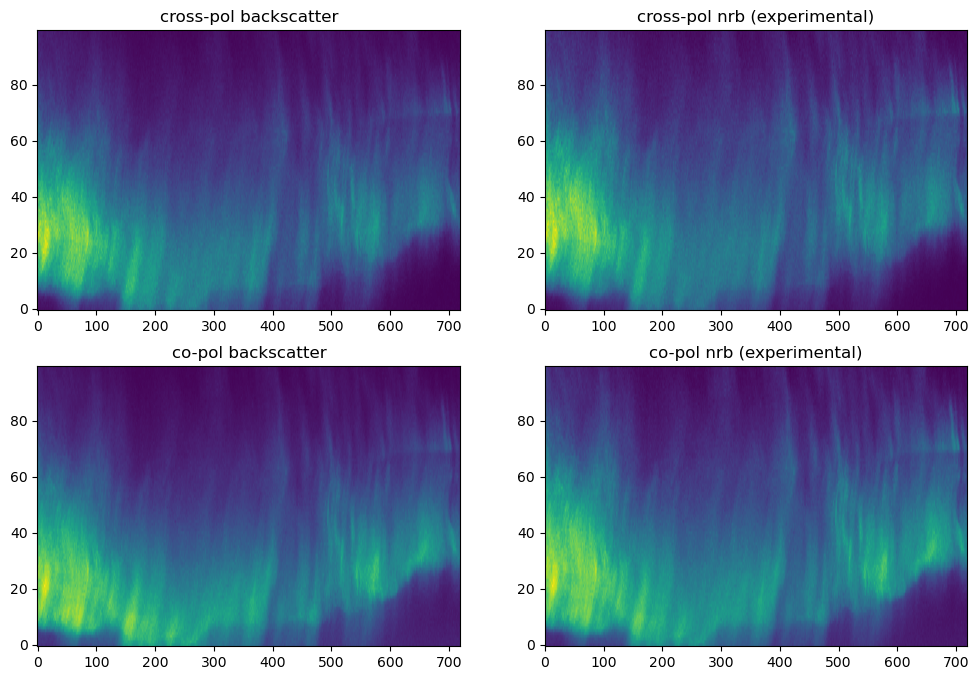

In [29]:
bs1 = data['channel_1'].values.T # cross-pol return signal
bs2 = data['channel_2'].values.T # co-pol return signal

nrb2 = data['nrb_copol'].values.T
nrb1 = data['nrb_crosspol'].values.T

print(bs2.shape)

#[200:300,:]
#[215:315,:]
bs1 = bs1[215:315,:]
bs2 = bs2[215:315,:]
nrb1 = nrb1[215:315,:]
nrb2 = nrb2[215:315,:]

print('Ranges:')
print(f'bs1 {np.max(bs1)}, {np.min(bs1)}')
print(f'bs2 {np.max(bs2)}, {np.min(bs2)}')
print(f'nrb1 {np.max(nrb1)}, {np.min(nrb1)}')
print(f'nrb2 {np.max(nrb2)}, {np.min(nrb2)}')


fig,ax = plt.subplots(2,2,figsize=(12,8))

ax[0,0].imshow(bs1,origin='lower',aspect='auto')
ax[0,0].set_title('cross-pol backscatter')

ax[1,0].imshow(bs2,origin='lower',aspect='auto')
ax[1,0].set_title('co-pol backscatter')

ax[0,1].imshow(nrb1,origin='lower',aspect='auto')
ax[0,1].set_title('cross-pol nrb (experimental)')
ax[1,1].imshow(nrb2,origin='lower',aspect='auto')
ax[1,1].set_title('co-pol nrb (experimental)')

'''
for i in range(2):
    for j in range(2):
        ax[i,j].colorbar()
        ax[i,j].clim(vmin=0)
'''

plt.show()

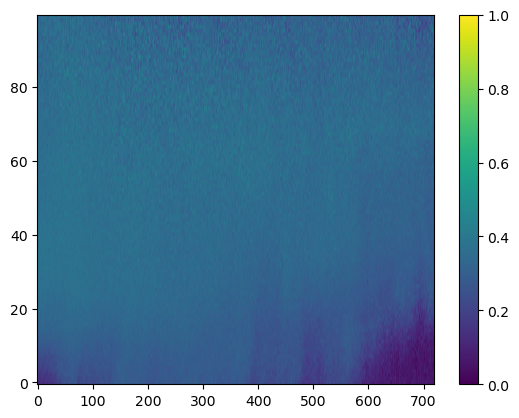

In [34]:
# plot the depolarization ratio
depol_nrb = nrb1 / (nrb1 + nrb2)
im = plt.imshow(depol_nrb,origin='lower',aspect='auto')
plt.colorbar(mappable=im)
plt.clim(0,1)

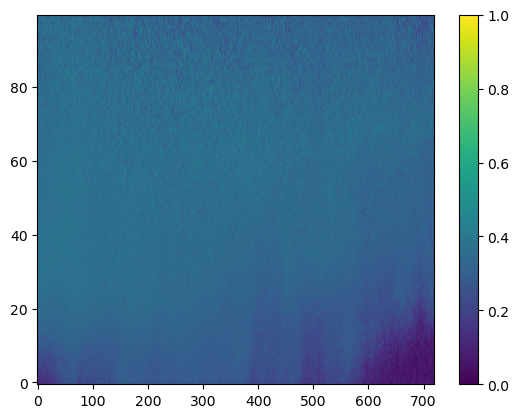

In [35]:
# plot the depolarization ratio from the backscatter
depol_bs = bs1 / (bs1 + bs2)
im = plt.imshow(depol_bs,origin='lower',aspect='auto')
plt.colorbar(mappable=im)
plt.clim(0,1)

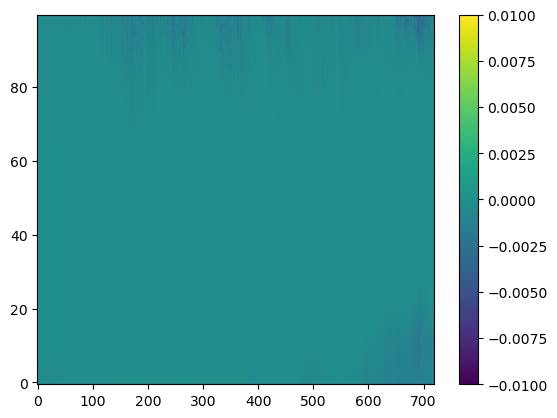

In [39]:
# plot the residuals between the calculated depol variables
depol_resid = depol_nrb - depol_bs
im = plt.imshow(depol_resid,origin='lower',aspect='auto')
plt.colorbar(mappable=im)
plt.clim(-0.01,0.01)

## Merging multiple Datasets

In [37]:
'''
del data

for i,f in enumerate(mpl_files):
    newdata = xr.open_dataset(os.path.join(root_path,'mpl',f))
    if i:
        data = xr.concat([data,newdata], dim='profile')
    else:
        data = newdata

data
'''

"\ndel data\n\nfor i,f in enumerate(mpl_files):\n    newdata = xr.open_dataset(os.path.join(root_path,'mpl',f))\n    if i:\n        data = xr.concat([data,newdata], dim='profile')\n    else:\n        data = newdata\n\ndata\n"